# Space Invaders own implementation

## Intro 
This is my first try to play the Atari game of SpaceInvaders with the use of tensorflow. Allthough there is some code out there I want to understand it myself. Hence here my own implementation.

## General
- [Stackoverflow]("https://stackoverflow.com/questions/42605769/openai-gym-atari-on-windows") about running Atari on Windows


## about OpenAI
- [Doku]("https://gym.openai.com/docs/")

## Step 1: Import the libraries

In [44]:
import gym 
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import transform
import numpy as np
from collections import deque
import tensorflow as tf
import random

## Step 2: Create the environment

In [2]:
env = gym.make('SpaceInvaders-v0')
env.reset()
env.render()

True

In [3]:
# let's check if it works
for i_episode in range(10):
    observation = env.reset()
    for t in range(100):
        env.render()
        observation
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("finisched")
            break

In [46]:
possible_actions = np.array(np.identity(env.action_space.n,dtype=int).tolist())
possible_actions


array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]])

## Step 3: Define the preprocessing functions
In this case we are receiving the fully coloered pictures. Even with the scores on top.


__Observation:__ Here we receive the image.

observation shape  (210, 160, 3)
reward 0.0


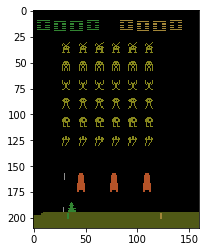

In [4]:
print("observation shape ", observation.shape)
plt.imshow(observation)
print("reward", reward)

In [6]:
def preProcessImage(observation):
    img = rgb2gray(observation) 
    img = img[20:-12,4:-12] # crop image
    img = img / 255 # normalize image
    img = transform.rescale(img, 1/1.9)
    return img

In [7]:
# stack 4 pictures 
# this is important so that the ai 
# is able to understand how the oponents move
img = preProcessImage(observation)

print("shape after processing", img.shape)

shape after processing (94, 76)


C:\Users\wilhe\Miniconda3\envs\gym3\lib\site-packages\skimage\transform\_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
C:\Users\wilhe\Miniconda3\envs\gym3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\wilhe\Miniconda3\envs\gym3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


### Stack frames

In [48]:
stack_size = 4 # We stack 4 frames

# Initialize deque with zero-images one array for each image
stacked_frames  =  deque([np.zeros(img.shape, dtype=np.int) for i in range(stack_size)], maxlen=4)

def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preProcessImage(state)
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros(img.shape, dtype=np.int) for i in range(stack_size)], maxlen=4)
        
        # Because we're in a new episode, copy the same frame 4x
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)
        
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2) 
    
    return stacked_state, stacked_frames

## Step 4: Setup Hyper Parameters

In [11]:
### MODEL HYPERPARAMETERS
state_size = [94, 76, 4]      # Our input is a stack of 4 frames hence 110x84x4 (Width, height, channels) 
action_size = env.action_space.n # 8 possible actions
learning_rate =  0.00025      # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
total_episodes = 50            # Total episodes for training
max_steps = 50000              # Max possible steps in an episode
batch_size = 64                # Batch size

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.00001           # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.9                    # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000          # Number of experiences the Memory can keep

### PREPROCESSING HYPERPARAMETERS
stack_size = 4                 # Number of frames stacked

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = False

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

## Step 5: Setup Deep Learning

In [41]:
class DQNetwork:
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        
        
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")
            self.actions = tf.placeholder(tf.float32, [None, self.action_size], name="actions")
            
            
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                          filters = 32,
                                          kernel_size = [8,8],
                                          strides = [4,4],
                                          padding = "VALID",
                                          kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(),
                                          name = "conv1")
            
            self.conv1_out = tf.nn.elu(self.conv1, name="conv1_out")
            
            
            self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                          filters = 64,
                                          kernel_size = [4,4],
                                          strides = [2,2],
                                          padding = "VALID",
                                          kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(),
                                          name = "conv2")
            
            self.conv2_out = tf.nn.elu(self.conv2, name="conv2_out")
            
            
            self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                          filters = 64,
                                          kernel_size = [3,3],
                                          strides = [2,2],
                                          padding = "VALID",
                                          kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(),
                                          name = "conv3")
            
            self.conv3_out = tf.nn.elu(self.conv3, name="conv3_out")
            
            self.flatten = tf.contrib.layers.flatten(self.conv3_out)
            
            self.fc = tf.layers.dense(inputs = self.flatten,
                                     units = 512,
                                     activation = tf.nn.elu,
                                     kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                     name = "fc1")
            
            self.output = tf.layers.dense(inputs = self.fc,
                                        units = self.action_size,
                                        activation = None)
            
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions))
            
            self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
            
            self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)                                             

In [42]:
tf.reset_default_graph()

DQNetwork = DQNetwork(state_size, action_size, learning_rate)

## Step 6: Experience Replay
[Experience Replay]("https://datascience.stackexchange.com/questions/20535/what-is-experience-replay-and-what-are-its-benefits")

In [43]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)
        
        return [self.buffer[i] for i in index]

In [52]:
memory = Memory(max_size=memory_size)
env.reset()
for i in range(pretrain_length):
    if i == 0:
        state = env.reset()        
        state, stacked_frames = stack_frames(stack_frames, state, True)
        
    choice = random.randint(1, len(possible_actions))-1
    #action = possible_actions[choice]
    next_state, reward, done, _ = env.step(choice)
    
    next_state, stacked_frames = stack_frames(stack_frames, next_state, False)
    
    
    if done:
        next_state = np.zeros(state.shape)
        
        memory.add((state, action, reward, next_state, done))
        
        state = env.reset()
        
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
        
    else:
        memory.add((state, action, reward, next_state, done))
        state = next_state

C:\Users\wilhe\Miniconda3\envs\gym3\lib\site-packages\skimage\transform\_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
C:\Users\wilhe\Miniconda3\envs\gym3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\wilhe\Miniconda3\envs\gym3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


AttributeError: 'function' object has no attribute 'append'

## Step 7: Set up Tensorboard 
[Tutorial]("https://www.youtube.com/embed/eBbEDRsCmv4")

## Step 8: Train your Agent

## Step 9: Test